In [95]:
# critical
import argparse
import os
import random
import time
import math

# machine learning
from sklearn.decomposition import PCA

# deep learning
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
import torchvision.utils as vutils

# data
import numpy as np
import pandas as pd

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# signal processing
from scipy import signal
from scipy.stats import entropy

In [96]:
# set random seed for reproducibility
manualSeed = 99
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)

np.random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # Needed for reproducible results

Random Seed:  99


In [97]:
device = torch.device("mps")

### Select Signals

In [98]:
gw_df = pd.read_csv('../data/gw-raw-data/richers_1764.csv')
parameters_df = pd.read_csv('../data/gw-raw-data/richers_1764_parameters.csv')
selected_indexes = parameters_df[parameters_df['beta1_IC_b'] > 0].index
gw_df = gw_df.iloc[:, selected_indexes]
signals = gw_df.values

### Apply Augmentation Methods

In [99]:
def reshape_signal(signal):
    reshaped_signals = np.empty(shape=(256, 0)).astype('float32')

    for i in range(signal.shape[1]):
        current_signal = signal[:, i].reshape(-1, 1)
        current_signal = current_signal[-256:]
        reshaped_signals = np.concatenate((reshaped_signals, current_signal), axis=1)

    return reshaped_signals

def shift_augmentation(signal):
    shifted_signals = np.empty(shape=(256, 0)).astype('float32')

    for i in range(signal.shape[1]):
        current_signal = signal[:, i].reshape(-1, 1)

        shift = np.random.normal(0, 25, 1)
        shifted_signal = np.roll(current_signal, int(shift), axis=0)
        shifted_signal = shifted_signal.reshape(-1, 1)

        shifted_signals = np.concatenate((shifted_signals, shifted_signal), axis=1)

    return shifted_signals

def scale_augmentation(signal):
    scaled_signals = np.empty(shape=(256, 0)).astype('float32')

    for i in range(signal.shape[1]):
        current_signal = signal[:, i].reshape(-1, 1)

        scale_factor = np.random.normal(1, 0.5, 1)
        scale_factor = np.maximum(scale_factor, 0)
        scaled_signal = scale_factor * signal

        scaled_signals = np.concatenate((scaled_signals, scaled_signal), axis=1)

    return scaled_signals



In [100]:
signals = reshape_signal(signals)
selected_indexes = [0, 1442, 1614]
selected_signals = signals[:, selected_indexes]

shifted_augmented_signals = shift_augmentation(selected_signals)
scaled_augmented_signals = scale_augmentation(selected_signals)
# mixture_augmented_signals = shift_augmentation(selected_signals)
# window_warped_augmented_signals = shift_augmentation(selected_signals)

/var/folders/qy/p5knypnd54x1dfyxqbs0175r0000gn/T/ipykernel_96577/4116381275.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  shifted_signal = np.roll(current_signal, int(shift), axis=0)


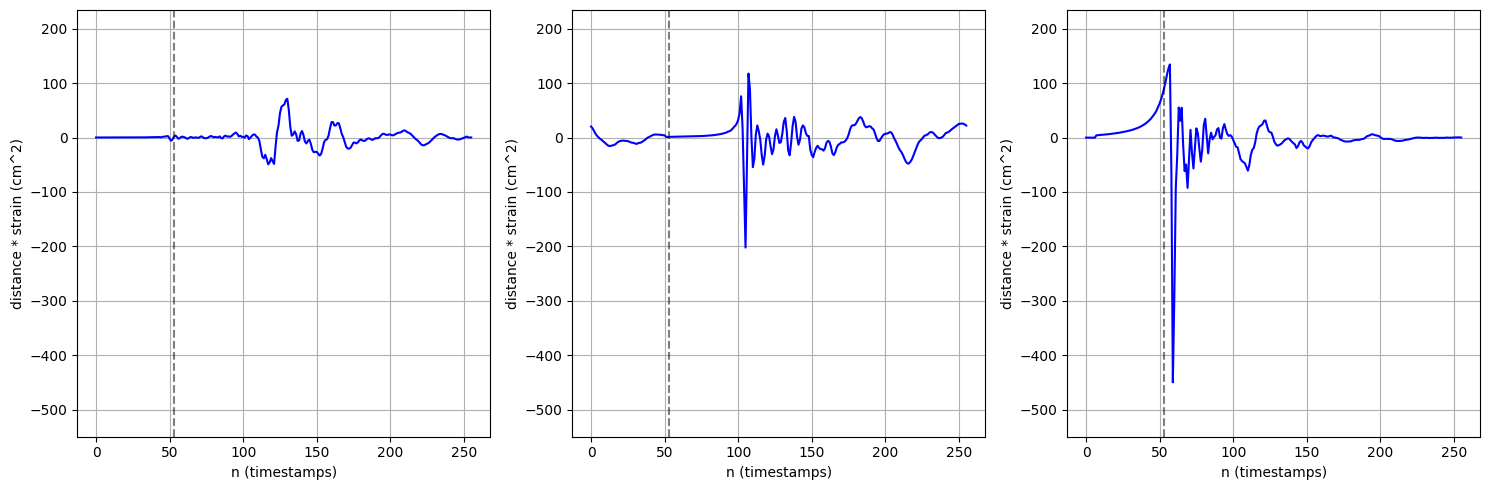

In [101]:
num_rows = 1
num_cols = 3

# Determine the common limits for all subplots
common_ylim = (shifted_augmented_signals.min().min() - 100, shifted_augmented_signals.max().max() + 100)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5))

axes = axes.flatten()

# plot each signal on a separate subplot
for i, ax in enumerate(axes):
    x = np.arange(len(shifted_augmented_signals))
    y = shifted_augmented_signals[:, i]
    ax.plot(x, y, color='blue')

    ax.axvline(x=53, color='black', linestyle='--', alpha=0.5)
    ax.grid(True)
    ax.set_ylim(common_ylim)
    
    # Add axis titles
    ax.set_ylabel('distance * strain (cm^2)')
    ax.set_xlabel('n (timestamps)')

for i in range(len(shifted_augmented_signals), num_rows*num_cols):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

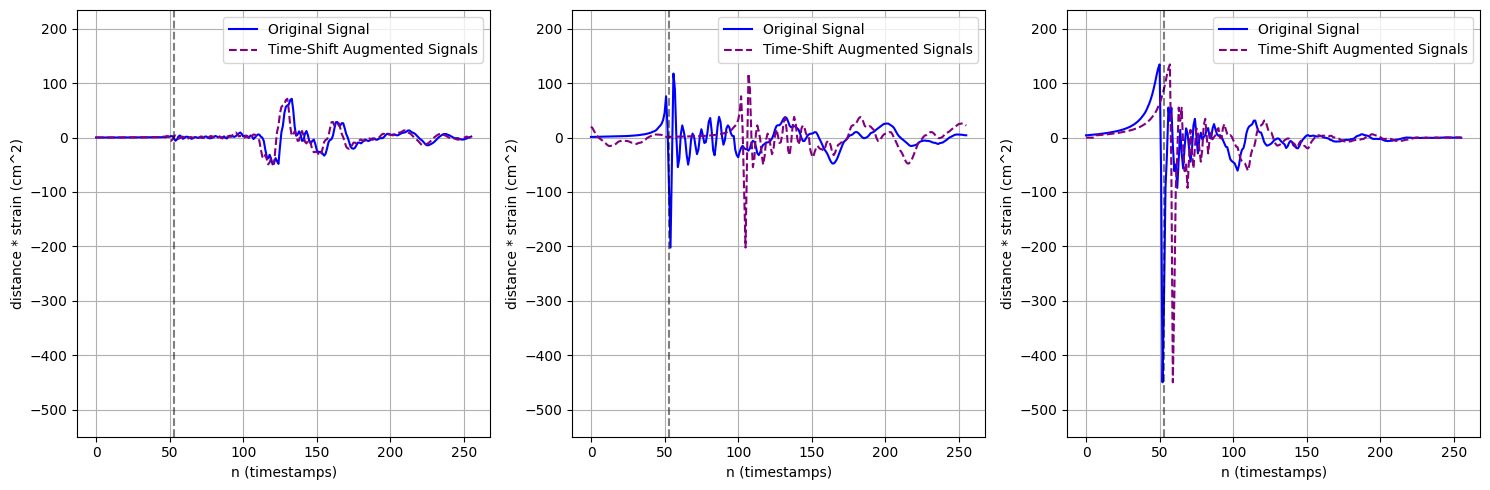

In [102]:
num_rows = 1
num_cols = 3

common_ylim = (min(shifted_augmented_signals.min(), selected_signals.min()) - 100, max(shifted_augmented_signals.max(), selected_signals.max()) + 100)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5))
axes = axes.flatten()

for i, ax in enumerate(axes):
    x = np.arange(len(selected_signals))

    y_selected = selected_signals[:, i]
    ax.plot(x, y_selected, color='blue', label='Original Signal')

    y_shifted = shifted_augmented_signals[:, i]
    ax.plot(x, y_shifted, color='purple', linestyle='--', label='Time-Shift Augmented Signals')

    ax.axvline(x=53, color='black', linestyle='--', alpha=0.5)
    ax.grid(True)
    ax.set_ylim(common_ylim)

    ax.set_ylabel('distance * strain (cm^2)')
    ax.set_xlabel('n (timestamps)')

    ax.legend()

for i in range(len(shifted_augmented_signals), num_rows*num_cols):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

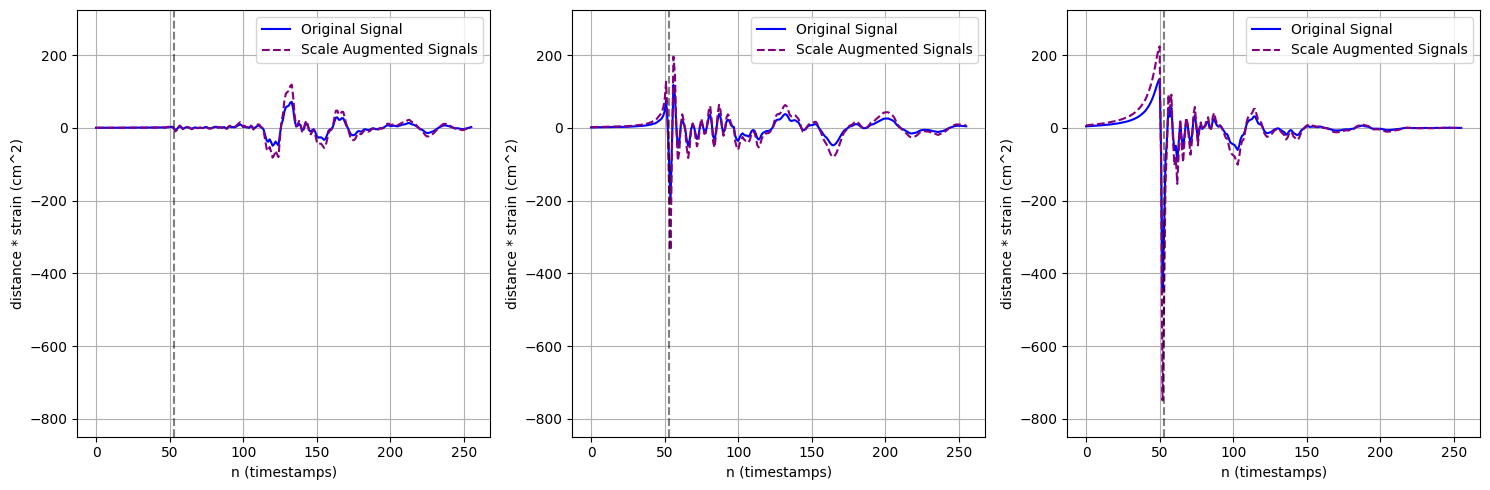

In [103]:
num_rows = 1
num_cols = 3

common_ylim = (min(scaled_augmented_signals.min(), selected_signals.min()) - 100, max(scaled_augmented_signals.max(), selected_signals.max()) + 100)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5))
axes = axes.flatten()

for i, ax in enumerate(axes):
    x = np.arange(len(selected_signals))

    y_selected = selected_signals[:, i]
    ax.plot(x, y_selected, color='blue', label='Original Signal')

    y_scaled = scaled_augmented_signals[:, i]
    ax.plot(x, y_scaled, color='purple', linestyle='--', label='Scale Augmented Signals')

    ax.axvline(x=53, color='black', linestyle='--', alpha=0.5)
    ax.grid(True)
    ax.set_ylim(common_ylim)

    ax.set_ylabel('distance * strain (cm^2)')
    ax.set_xlabel('n (timestamps)')

    ax.legend()

for i in range(len(scaled_augmented_signals), num_rows*num_cols):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()